# МТС Библиотека


Данные из приложения МТС Библиотека по взаимодействиям пользователей с книгами за 2 года.

В отдельных файлах есть:

* факты чтения книг пользователями
* описание книг
* описание пользователей


__Описание данных:__

В датасете собраны данные по пользователям и книгам, а также по их взаимодействиям (прочтение книги пользователем) из сервиса МТС Библиотека. Данные по чтению пользователями книг собраны за `2` два года, с `01-01-2018` по `31-12-2019` включительно, и разбавлены случайным шумом. ID пользователей и книг анонимизированы.

МТС Библиотека - приложение для чтения электронных книг, прессы и прослушивания аудиокниг, доступно для абонентов всех мобильных операторов, продукт экосистемы МТС. 

__Задача:__

Необходимо наиболее точно порекомендовать список из 10 книг для каждого пользователя из тестовой выборки. На платформе соревнования хранится тестовая выборка с реальными данными (пользователями и книгами, которые они прочитали за эти 2 дня). Данные скрыты. Kaggle посчитает метрику качества вашего предсказания: насколько оно совпадает с реальными данными

__Метрика качества:__

Метрика качества в соревновании - __map@10__ или __map@K, K = 10__.

Формат файла `sample_submission.csv`:
* Id - список ID пользователей, по которым нужно сделать прогноз
* Predicted - список ID книг, которые нужно предсказать. Это строка, где разделитель для ID - это пробел.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

# I. Загрузка и описание данных.

In [5]:
!gdown --id 1bgefQe0PW4JeGlnbISsusG9b6wF9B-Ch # users
!gdown --id 1Q9kWBdSUGfvdwl_5idWLpiexPXdRY5iN # items
!gdown --id 1LJ4moWL5SR8OmVsB2Mt0l7rmnRrnK8Ou # interactions
!gdown --id 1hZEnLc4_mb-ozvTvKVM6RERYO3JoO2gF # sample_submission

Downloading...
From: https://drive.google.com/uc?id=1bgefQe0PW4JeGlnbISsusG9b6wF9B-Ch
To: /content/users.csv
100% 2.24M/2.24M [00:00<00:00, 69.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Q9kWBdSUGfvdwl_5idWLpiexPXdRY5iN
To: /content/items.csv
100% 11.2M/11.2M [00:00<00:00, 98.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LJ4moWL5SR8OmVsB2Mt0l7rmnRrnK8Ou
To: /content/interactions.csv
100% 44.6M/44.6M [00:00<00:00, 165MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hZEnLc4_mb-ozvTvKVM6RERYO3JoO2gF
To: /content/sample_submission.csv
100% 259k/259k [00:00<00:00, 37.5MB/s]


In [6]:
users = pd.read_csv('users.csv')
items = pd.read_csv('items.csv')
interactions = pd.read_csv('interactions.csv')
sample_submission = pd.read_csv('sample_submission.csv')

### `users` 

информация о пользователях

- `user_id` - ID пользователя, int64
- `age` - возрастная группа пользователя, строка вида "M_N"
- `sex` - пол пользователя, 1/0

In [7]:
users.sample(2)

,user_id,age,sex
122322,148013,55_64,0.0
62334,75529,45_54,0.0


### `items` 

информация о книгах

- `item_id` - ID книги, int64
- `title` - название книги, строка
- `genres` - жанры, строка с разделителем ','
- `authors` - авторы, строка с разделителем ','
- `year` - год публикации, строка (найдите, почему 🤔)


In [8]:
items.sample(2)

,id,title,genres,authors,year
1444,317508,Руководство по системной поведенченской психот...,"Психологическая консультация,Психотерапия","Андрей Курпатов,Геннадий Аверьянов",NaN
44835,353928,Твой день 112-2014,"Развлечения,Газеты",NaN,2014


### `interactions` 

взаимодействия пользователей и книг

- `user_id` - ID пользователя, int64
- `item_id` - ID книги, int64
- `progress` - прогресс по чтению в процентах, int8
- `rating` - рейнтинг книги выставленный пользователем, от 1 до 5, **много пропущенных значений**
- `start_date` - дата начала чтения книги пользователем

In [9]:
interactions.sample(2)

,user_id,item_id,progress,rating,start_date
1316338,65773,299286,33,0.0,2019-09-07
1303228,100217,300427,12,NaN,2019-09-01


# II. Первичный анализ данных.

## Информация о пользователях

Распределение пользователей по полу в зависимости от значений возраста.

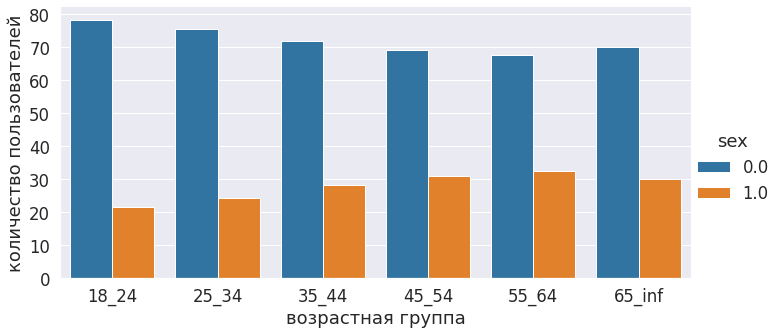

In [10]:
with sns.plotting_context('notebook', font_scale=1.5), \
    sns.axes_style('darkgrid'):

    tmp_df = (users.groupby("age")['sex'].value_counts(normalize=True))
    tmp_df = tmp_df.mul(100).rename('количество пользователей').reset_index()
    g = sns.catplot(
        data=tmp_df,
        x="age",
        y='количество пользователей',
        kind='bar',
        hue='sex',
        height=5,
        aspect=2,
    )
    plt.xlabel("возрастная группа")

__Вывод:__ в среднем мужчин больше в 2-3 раза, чем женьщин.

## Информация о книгах

Наиболее популярные жанры в базе.

In [11]:
from collections import Counter


counter = Counter()
for genre in items.genres:
    if type(genre) != float:
        item_genres = genre.split(',')
        counter.update(item_genres)

In [12]:
counter.most_common(10)

[('Современная русская литература', 3893),
 ('Современные детективы', 3441),
 ('Современные любовные романы', 3247),
 ('Попаданцы', 2832),
 ('Боевая фантастика', 2814),
 ('Любовное фэнтези', 2621),
 ('Русская классика', 2537),
 ('Газеты', 2441),
 ('Героическое фэнтези', 2234),
 ('Зарубежные любовные романы', 2214)]

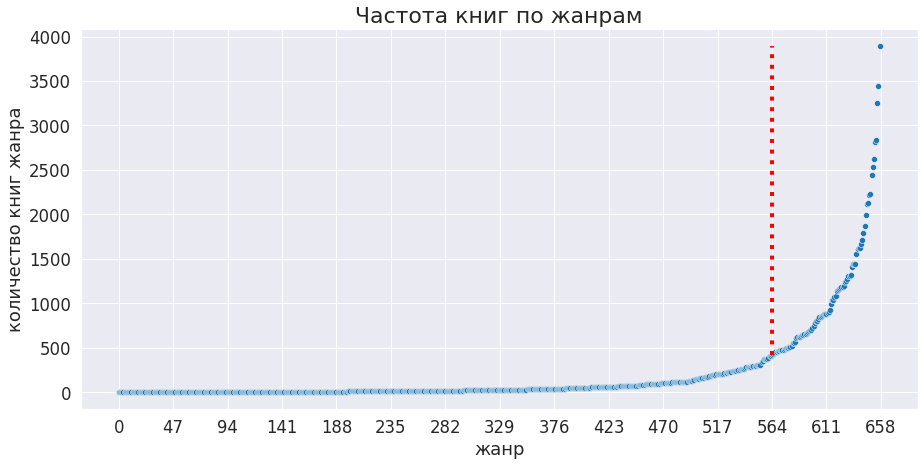

In [13]:
with sns.plotting_context('notebook', font_scale=1.5), \
    sns.axes_style('darkgrid'):

    plt.figure(figsize=(15,7))
    sns.scatterplot(x=np.arange(len(counter.values())), 
                    y=sorted(counter.values()))
    plt.vlines(564, 
               ymin=list(sorted(counter.values()))[564], 
               ymax=list(sorted(counter.values()))[-1], 
               colors='red', ls=':', lw=4)
    plt.title('Частота книг по жанрам', fontsize=22)
    plt.xlabel('жанр', fontsize=18)
    plt.ylabel('количество книг жанра', fontsize=18)
    plt.xticks(np.arange(0, len(counter.values()) + 1, 47))

In [14]:
len(counter.values())

658

__Вывод:__ Примерно 100 жанров из 658 выделяется из всех. Остальных мало в базе.

Авторы с наибольшим количеством различных книг (с учетом аудиокниг).

In [15]:
items.authors.value_counts().head(10)

Дарья Донцова           320
Марина Серова           319
Наталья Александрова    287
Илья Мельников          270
Антон Чехов             269
Лев Толстой             224
Александр Тамоников     217
Владимир Колычев        204
Сергей Зверев           202
Кир Булычев             183
Name: authors, dtype: int64

Пример одного из авторов.

In [16]:
items.iloc[np.where(items.authors=='Антон Чехов')[0]].sort_values(by='title').sample(5)

,id,title,genres,authors,year
1,256084,Скрипка Ротшильда,"Классическая проза,Литература 19 века,Русская ...",Антон Чехов,1894
2540,44566,Воры,Русская классика,Антон Чехов,NaN
40947,321537,По делам службы,Русская классика,Антон Чехов,NaN
40686,189128,Хрестоматия. часть 1,"Литература 19 века,Русская классика",Антон Чехов,2013
40780,113597,Невеста,"Русский язык как иностранный,Список школьной л...",Антон Чехов,1903


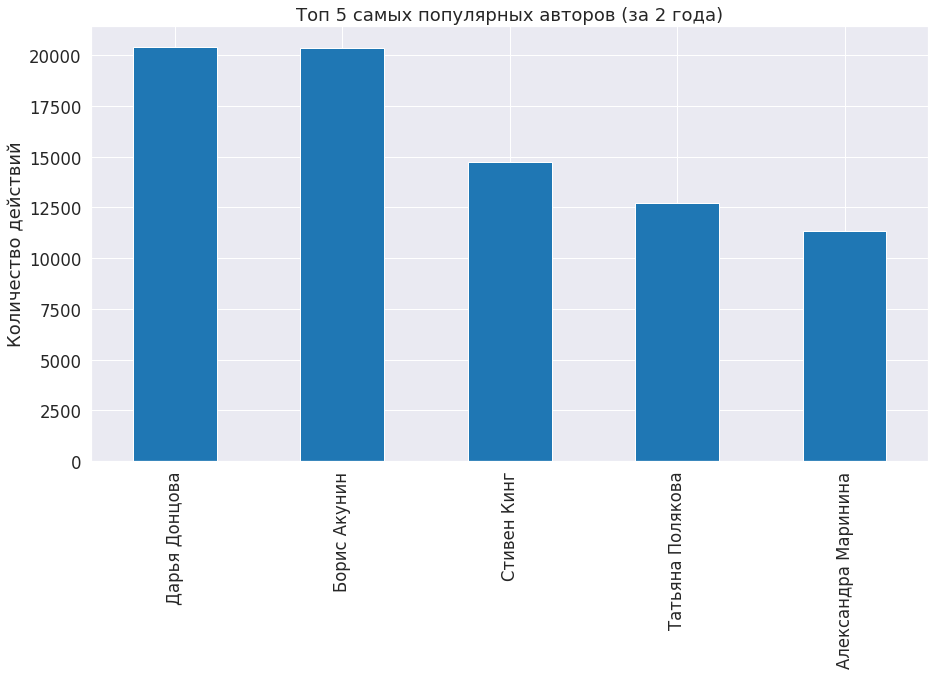

In [17]:
with sns.plotting_context('notebook', font_scale=1.5), \
    sns.axes_style('darkgrid'):

        plt.figure(figsize=(15,8))
        
        interactions.merge(items,
                           left_on='item_id',
                           right_on='id'
        )['authors'].value_counts().head(5).plot.bar()
        plt.title('Топ 5 самых популярных авторов (за 2 года)', fontsize=18)
        plt.ylabel('Количество действий', fontsize=18)

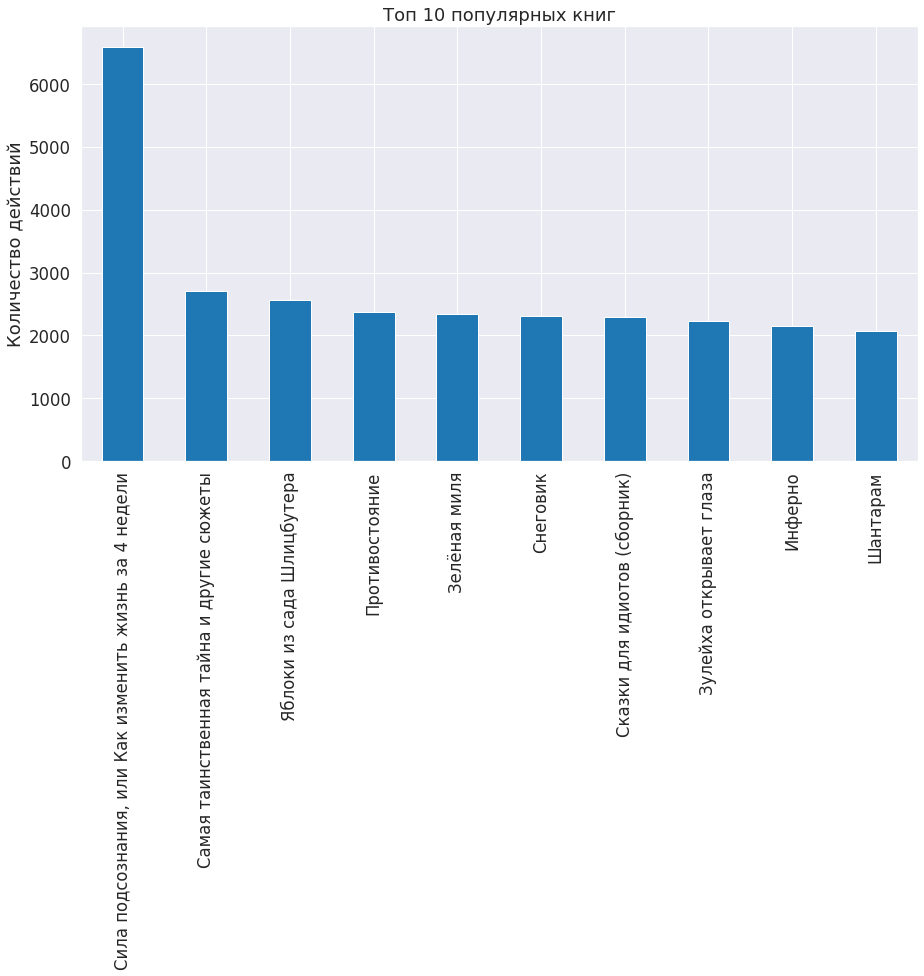

In [18]:
with sns.plotting_context('notebook', font_scale=1.5), \
    sns.axes_style('darkgrid'):

        plt.figure(figsize=(15,8))
        
        interactions.merge(items,
                           left_on='item_id',
                           right_on='id'
        )['title'].value_counts().head(10).plot.bar()
        plt.title('Топ 10 популярных книг', fontsize=18)
        plt.ylabel('Количество действий', fontsize=18)

## Информация о действиях пользователей

__Колонка `rating`__.

К сожалению, много пропусков в столбце рейтинга. Похоже, мало кто любит оценивать книги.

Информация действий пользователей дана за __729__ дней.

In [19]:
interactions['start_date'] = pd.to_datetime(interactions['start_date'])

print(interactions.start_date.min(), 
      interactions.start_date.max(),
      (interactions.start_date.max() - interactions.start_date.min()).days, 
      sep="\n") 

2018-01-01 00:00:00
2019-12-31 00:00:00
729


Количество различных пользователей.

In [20]:
interactions.user_id.nunique()

158325

In [21]:
interactions['start_date_year'] = interactions.start_date.apply(lambda x:x.year)
interactions['start_date_month'] = interactions.start_date.apply(lambda x:x.month)

In [22]:
interactions.groupby(['start_date_year'])['item_id'].count()

start_date_year
2018    778865
2019    783752
Name: item_id, dtype: int64

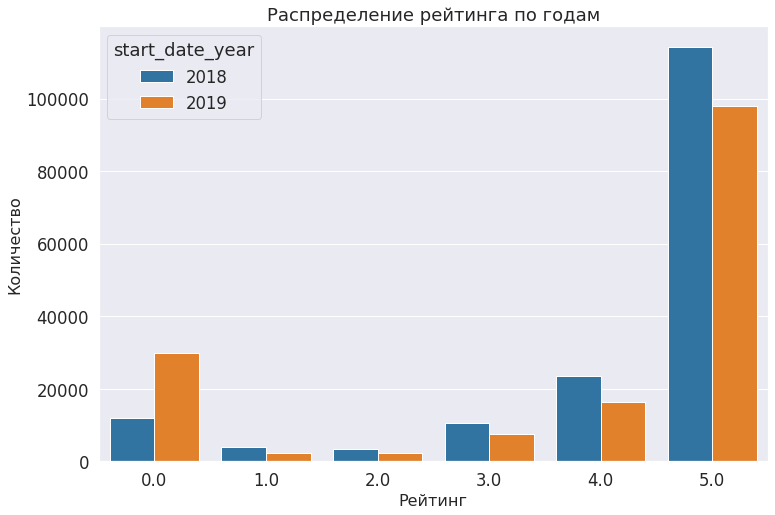

In [23]:
with sns.plotting_context('notebook', font_scale=1.5), \
    sns.axes_style('darkgrid'):

        plt.figure(figsize=(12,8))
        sns.countplot(x=interactions.rating,
                      hue = interactions.start_date_year)
        plt.title('Распределение рейтинга по годам', fontsize=18)
        plt.ylabel('Количество', fontsize=16)
        plt.xlabel('Рейтинг', fontsize=16)

Значение 0 в рейтинге скорее всего говорит о том что пользователь отказался оценивать. В 2019 намного больше рейтинга со значением 0.

Топ 5 самых оцениваемых книг.

In [24]:
top_5 = interactions.groupby('item_id')['rating']\
                    .agg(['count']).sort_values(by=['count'],
                                                ascending=False).head(5)
top_5_ind = [np.where(items.id==i)[0][0] for i in top_5.index.to_list()]
items.iloc[top_5_ind][['title', 'genres', 'authors']]

,title,genres,authors
14794,Зулейха открывает глаза,Современная русская литература,Гузель Яхина
13590,Черновик,Научная фантастика,Сергей Лукьяненко
40974,Дневники стюардессы. Лихие 90-е,"Шпионские детективы,Короткие любовные романы,К...",Дарья Кова
20558,Снеговик,"Зарубежные детективы,Триллеры,Полицейские дете...",Ю Несбё
27164,"Богатый папа, бедный папа. Роберт Кийосаки (об...","Личная эффективность,Саморазвитие / личностный...",Том Батлер-Боудон


# III. Предобработка данных

Удаление дубликатов.

In [25]:
duplicates = interactions.duplicated(
    subset=['user_id', 'item_id'], keep=False
)
interactions_duplicates = interactions[duplicates].sort_values(
    by=['user_id', 'start_date']
)
interactions = interactions[~duplicates]
interactions_duplicates = (
    interactions_duplicates.groupby(['user_id', 'item_id']).agg({
        'progress': 'max',
        'rating': 'max',
        'start_date': 'min'
    })
)

interactions = interactions.append(interactions_duplicates.reset_index(), 
                                   ignore_index=True)

In [26]:
interactions

,user_id,item_id,progress,rating,start_date,start_date_year,start_date_month
0,90133,82910,100,NaN,2018-01-01,2018.0,1.0
1,159130,331068,70,NaN,2018-01-01,2018.0,1.0
2,80061,26540,69,4.0,2018-01-01,2018.0,1.0
3,12811,301895,16,NaN,2018-01-01,2018.0,1.0
4,5778,127872,100,NaN,2018-01-01,2018.0,1.0
...,...,...,...,...,...,...,...
1562500,160045,291585,85,NaN,2018-02-25,NaN,NaN
1562501,161224,7819,58,NaN,2018-04-25,NaN,NaN
1562502,163719,27040,99,NaN,2018-05-11,NaN,NaN
1562503,165754,303933,42,0.0,2018-08-09,NaN,NaN


In [27]:
diff = np.setdiff1d(users['user_id'], interactions['user_id'].unique())
num_users = len(users['user_id'])
for i, user_id in tqdm(enumerate(users['user_id'])):
    if user_id in diff:
        users = users.drop(i)

0it [00:00, ?it/s]

In [28]:
diff = np.setdiff1d(interactions['user_id'].unique(), users['user_id'])
unknowns = ['unknown'] * len(diff)
users_with_interactions = pd.DataFrame(list(zip(diff, unknowns, unknowns)),
                                       columns=users.columns)
users = users.append(users_with_interactions)

Эта колонка будет определять, каким образом юзеры будут разделяться на две группы. Тем, у кого достаточно интеракций (соответственно, о них больше информации), рекомендации составляются BM25Recommender. Остальным будет рекомендоваться популярное.

In [29]:
num_interactions = []
for user in tqdm(users['user_id']):
    num_interactions.append(len(interactions[interactions['user_id'] == user]))
users['num_its'] = num_interactions

  0%|          | 0/158325 [00:00<?, ?it/s]

In [30]:
users

,user_id,age,sex,num_its
0,0,45_54,1,10
1,1,25_34,0,6
2,2,45_54,0,6
3,3,65_inf,0,5
4,4,18_24,0,3
...,...,...,...,...
27512,166004,unknown,unknown,4
27513,166023,unknown,unknown,10
27514,166055,unknown,unknown,6
27515,166063,unknown,unknown,5


In [31]:
items

,id,title,genres,authors,year
0,248031,Ворон-челобитчик,"Зарубежные детские книги,Сказки,Зарубежная кла...",Михаил Салтыков-Щедрин,1886
1,256084,Скрипка Ротшильда,"Классическая проза,Литература 19 века,Русская ...",Антон Чехов,1894
2,134166,Испорченные дети,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1869
3,281311,Странный человек,"Пьесы и драматургия,Литература 19 века",Михаил Лермонтов,1831
4,213473,Господа ташкентцы,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1873
...,...,...,...,...,...
63753,143203,Игрушка палача,"Эротические романы,Любовно-фантастические рома...",Эрика Адамс,2019
63754,27324,Любовь под развесистой клюквой,Современные любовные романы,Маргарита Южина,NaN
63755,359711,"Куда уходят грешницы, или Гробница Наполеона",Современные детективы,Наталья Андреева,NaN
63756,283955,Сварить медведя,"Зарубежные детективы,Исторические детективы,За...",Микаель Ниеми,2017


Лучшей эффективности Popular Recommender достигал при days=30. Что логично, учитывая специфику данных.

In [32]:
class Popular_Recommender():
    def __init__(self, max_K=100, days=30, item_column='item_id', dt_column='date'):
        self.max_K = max_K
        self.days = days
        self.item_column = item_column
        self.dt_column = dt_column
        self.recommendations = []
        
    def fit(self, df):
        min_date = pd.to_datetime(df[self.dt_column]).max().normalize() - pd.DateOffset(days=self.days)
        self.recommendations = df.loc[pd.to_datetime(df[self.dt_column]) > min_date, self.item_column].value_counts().head(self.max_K).index.values

In [33]:
pop_rec = Popular_Recommender(days=30, dt_column='start_date')
pop_rec.fit(interactions)
populars = list(pop_rec.recommendations[:10])

In [2]:
# !pip install implicit
!pip install implicit==0.4.4
# !pip uninstall implicit

     |████████████████████████████████| 1.1 MB 5.4 MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp37-cp37m-linux_x86_64.whl size=3415649 sha256=6addfeff397a798f9d434e0df33d761f65a1abadf191875051c229462439c9c6
  Stored in directory: /root/.cache/pip/wheels/44/7e/7d/a17324ea207cfbe76aca878b5b8ca0aa932cf55d163329be37
Successfully built implicit


In [3]:
from implicit.nearest_neighbours import BM25Recommender
import scipy.sparse as sp

Разделение.

In [34]:
dropped_users = []
n_interactions = 5

for user in tqdm(sample_submission['Id']):
    if user not in users['user_id'].unique():
        dropped_users.append(user)
    elif users[users['user_id'] == user]['num_its'].item() < n_interactions:
        dropped_users.append(user)

  0%|          | 0/3074 [00:00<?, ?it/s]

In [35]:
remained_users = users[users['user_id'].isin(np.setdiff1d(sample_submission['Id'], dropped_users))]

In [36]:
len(remained_users), len(dropped_users)

(2532, 542)

In [37]:
def get_coo_matrix(interactions, 
                   users_mapping, 
                   items_mapping,
                   user_col='user_id', 
                   item_col='item_id', 
                   weight_col=None):
    if weight_col is None:
        weights = np.ones(len(interactions), dtype=np.float32)
    else:
        weights = interactions[weight_col].astype(np.float32)

    interaction_matrix = sp.coo_matrix((
        weights, 
        (
            interactions[user_col].map(users_mapping.get), 
            interactions[item_col].map(items_mapping.get)
        )
    ))
    return interaction_matrix

def make_mapping(data):
    return dict([(v, k) for k, v in enumerate(data)])

In [38]:
users_mapping = make_mapping(interactions['user_id'].unique())
items_mapping = make_mapping(items['id'].unique())

items_inv_mapping = dict({(v, k) for k, v in items_mapping.items()})

In [39]:
interactions_matrix = get_coo_matrix(interactions, 
                                     users_mapping=users_mapping, 
                                     items_mapping=items_mapping).tocsr()

In [40]:
imp_model = BM25Recommender(K=8)
imp_model.fit(interactions_matrix.T) 

  0%|          | 0/63758 [00:00<?, ?it/s]

Предсказания.

In [41]:
TOP_N = 10

total_preds = dict()

for user in dropped_users:
    total_preds[user] = populars

for user in remained_users['user_id']:
    preds = imp_model.recommend(users_mapping[user], interactions_matrix, 
                               N=TOP_N, filter_already_liked_items=True)
    preds = [items_inv_mapping[pred[0]] for pred in preds]
    
    total_preds[user] = preds


Сохранение сабмита.

In [42]:
submission = pd.DataFrame({'Id': sample_submission['Id']})
submission['Predicted'] = [total_preds[user] for user in submission['Id']]
submission['Predicted'] = submission['Predicted'].apply(lambda x: ' '.join(map(str, x)))

In [43]:
submission

,Id,Predicted
0,10001,296208 297168 235765 237354 234997 270194 7967...
1,10002,378939 43309 327688 240408 54436 234926 12597 ...
2,100152,82211 5526 167562 210478 113057 137774 44107 2...
3,100197,179505 268152 267417 247795 285127 351206 8226...
4,100284,343815 168733 273724 312572 240559 170741 1163...
...,...,...
3069,99734,74523 71718 328046 44210 108206 26094 150282 1...
3070,99757,283713 276903 184549 168963 55466 143175 38528...
3071,99772,295325 372896 374175 77074 182009 197534 33545...
3072,99827,59710 332422 333753 275148 149928 347571 21399...
